# Coursework

## Question 1

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential, Model # imports our type of network
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout # imports our layers we want to use

from tensorflow.python.keras.losses import categorical_crossentropy #loss function
from tensorflow.keras.optimizers import Adam, SGD #optimisers
from tensorflow.keras.utils import to_categorical #some function for data preparation

In [2]:
batch_size = 128
num_classes = 19
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [3]:
images = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

np.random.seed(73289)

In [4]:
def create_combined_dataset(iamges, labels, dataset_size=10000):
    combined_images = []
    combined_labels = []
    
    for _ in range(dataset_size):
        idx1, idx2 = np.random.choice(np.arange(len(images)), 2, replace=True)
        img1, img2 = images[idx1], images[idx2]
        label1, label2 = labels[idx1], labels[idx2]
        
        combined_image = np.vstack((img1, img2))
        combined_label = label1 + label2
        
        combined_images.append(combined_image)
        combined_labels.append(combined_label)
        
    combined_images = np.array(combined_images).reshape(-1, 56, 28, 1)
    combined_labels = np.array(combined_labels)
    
    return combined_images, combined_labels

In [5]:
dataset_size = 100000
train_size = int(0.7 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

print("Train size: ", train_size)
print("Validation size: ", val_size)
print("Test size: ", test_size)

Train size:  70000
Validation size:  10000
Test size:  20000


In [6]:
combined_images, combined_labels = create_combined_dataset(images, labels, dataset_size)

(56, 28, 1)
11


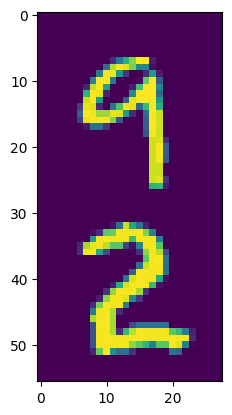

In [7]:
print(combined_images[0].shape)
print(combined_labels[0])
plt.imshow(combined_images[0])

In [8]:
# Split dataset
train_images, train_labels = combined_images[:train_size], combined_labels[:train_size]
val_images, val_labels = combined_images[train_size:train_size+val_size], combined_labels[train_size:train_size+val_size]
test_images, test_labels = combined_images[train_size+val_size:], combined_labels[train_size+val_size:]

In [19]:
train_labels = to_categorical(train_labels, num_classes)
val_labels = to_categorical(val_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [20]:
print("Train images shape: ", train_images.shape)
print("Validation images shape: ", val_images.shape)
print("Test images shape: ", test_images.shape)

Train images shape:  (70000, 56, 28, 1)
Validation images shape:  (10000, 56, 28, 1)
Test images shape:  (20000, 56, 28, 1)


## Question 2

In [27]:
model = Sequential([
    Input(shape=(56, 28, 1)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

In [29]:
model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=128)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3241 - loss: 0.0409 - val_accuracy: 0.7362 - val_loss: 0.0197
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7449 - loss: 0.0191 - val_accuracy: 0.8124 - val_loss: 0.0141
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8208 - loss: 0.0138 - val_accuracy: 0.8426 - val_loss: 0.0121
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8536 - loss: 0.0115 - val_accuracy: 0.8642 - val_loss: 0.0105
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8733 - loss: 0.0100 - val_accuracy: 0.8734 - val_loss: 0.0099
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8876 - loss: 0.0088 - val_accuracy: 0.8872 - val_loss: 0.0087
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9021 - loss: 0.0077 - val_accuracy: 0.8990 - val_loss: 0.0080
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9115 - loss: 0.0071 - val_accuracy: 0.

In [30]:
test_loss, test_mae = model.evaluate(test_images, test_labels)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.9298 - loss: 0.0058


In [31]:
import optuna

In [37]:
def objective(trial):
    # Suggest values for hyperparameters
    num_units_layer1 = trial.suggest_int("units_layer1", 256, 512, step=32)
    num_units_layer2 = trial.suggest_int("units_layer2", 256, 512, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])

    # Build the model
    model = Sequential([
        Input(shape=(56, 28, 1)),
        Flatten(),
        Dense(num_units_layer1, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_units_layer2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=10,  # Use a small number of epochs for tuning
        batch_size=batch_size,
        verbose=0  # Suppress output for faster tuning
    )
    
    # Evaluate the model on validation data
    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy
    return -val_accuracy


In [38]:
# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)  # Run 50 trials

best_params = study.best_params
best_accuracy = -study.best_value  # Negate the value to get accuracy
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

[I 2024-11-29 01:27:10,532] A new study created in memory with name: no-name-e14b92d1-8b91-44f0-a066-90b3e0e26a3d
[I 2024-11-29 01:27:21,405] Trial 0 finished with value: -0.9114999771118164 and parameters: {'units_layer1': 320, 'units_layer2': 512, 'dropout_rate': 0.4, 'learning_rate': 0.0010601102234192555, 'batch_size': 256}. Best is trial 0 with value: -0.9114999771118164.
[I 2024-11-29 01:27:29,320] Trial 1 finished with value: -0.8845000267028809 and parameters: {'units_layer1': 256, 'units_layer2': 288, 'dropout_rate': 0.4, 'learning_rate': 0.0012649552802624507, 'batch_size': 512}. Best is trial 0 with value: -0.9114999771118164.
[I 2024-11-29 01:27:49,732] Trial 2 finished with value: -0.9286999702453613 and parameters: {'units_layer1': 320, 'units_layer2': 448, 'dropout_rate': 0.2, 'learning_rate': 0.0010826915880664443, 'batch_size': 128}. Best is trial 2 with value: -0.9286999702453613.
[I 2024-11-29 01:28:09,253] Trial 3 finished with value: -0.9028000235557556 and paramet

Best parameters: {'units_layer1': 320, 'units_layer2': 448, 'dropout_rate': 0.2, 'learning_rate': 0.0010826915880664443, 'batch_size': 128}
Best validation accuracy: 0.9287


In [39]:
# Build the best model with the optimized parameters
best_model = Sequential([
    Flatten(input_shape=(56, 28, 1)),
    Dense(best_params['units_layer1'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_layer2'], activation='relu'),
    Dense(num_classes, activation='softmax')
])

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the best model on the full training set
best_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=best_params['batch_size']
)

best_model.evaluate(test_images, test_labels)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3792 - loss: 1.8874 - val_accuracy: 0.7807 - val_loss: 0.7199
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7916 - loss: 0.6867 - val_accuracy: 0.8408 - val_loss: 0.5187
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8568 - loss: 0.4727 - val_accuracy: 0.8775 - val_loss: 0.4021
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8884 - loss: 0.3591 - val_accuracy: 0.8940 - val_loss: 0.3499
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9102 - loss: 0.2914 - val_accuracy: 0.9039 - val_loss: 0.3160
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9265 - loss: 0.2365 - val_accuracy: 0.9112 - val_loss: 0.2936
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9366 - loss: 0.2018 - val_accuracy: 0.9217 - val_loss: 0.2700
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9428 - loss: 0.1769 - val_accuracy: 0.

[0.30350470542907715, 0.9323999881744385]